In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline

## Helper Functions

In [2]:
def make_polynomial(x, D):
    N = len(x)
    X = np.empty((N, D+1))
    for d in range(D+1):
        X[:,d] = x**d
        if d > 1:
            X[:,d] = (X[:,d] - X[:,d].mean()) / X[:, d].std()
    return X

In [3]:
def f(X):
    return np.sin(X)

## Global Parameters

In [4]:
num_datasets = 50
noise_variance = 0.5
maximum_polynomial_degree = 12
N = 25
Ntrain = int(0.9*N)
np.random.seed(2)

## Make independent and dependent variables

In [5]:
x_axis = np.linspace(-np.pi, np.pi, 100)
y_axis = f(x_axis)

In [6]:
X = np.linspace(-np.pi, np.pi, N)
np.random.shuffle(X)
f_X = f(X)

In [7]:
Xpoly = make_polynomial(X, maximum_polynomial_degree)

## Init Trackers

In [8]:
train_scores = np.zeros((num_datasets, maximum_polynomial_degree))
test_scores = np.zeros((num_datasets, maximum_polynomial_degree))
train_predictions = np.zeros((Ntrain, num_datasets, maximum_polynomial_degree))
prediction_curves = np.zeros((100, num_datasets, maximum_polynomial_degree))

## Build

Cell below builds all the models, storing the prediction curve, the train/test predictions and the train/test scores for each polynomial degree.

In [9]:
model = LinearRegression()
for k in range(num_datasets):
    Y = f_X + np.random.randn(N)*noise_variance
    
    X_train = Xpoly[:Ntrain]
    y_train = Y[:Ntrain]
    
    X_test = Xpoly[:Ntrain]
    y_test = Y[Ntrain:]
    
    for d in range(maximum_polynomial_degree):
        model.fit(X_train[:,:d+2], y_train)
        predictions = model.predict(Xpoly[:,:d+2])
        
        x_axis_poly = make_polynomial(x_axis, d+1)
        prediction_axis = model.predict(x_axis_poly)
        
        prediction_curves[:,k,d] = prediction_axis
        
        train_prediction = predictions[:Ntrain]
        test_prediction = predictions[Ntrain:]
        
        train_predictions[:,k,d] = train_prediction
        
        train_score = mse(train_prediction, y_train)
        test_score = mse(test_prediction, y_test)
        
        train_scores[k,d] = train_score
        test_scores[k,d] = test_score

## Plot Prediction Curves

The prediction curves are in green, while the average of all prediction curves is shown in blue.

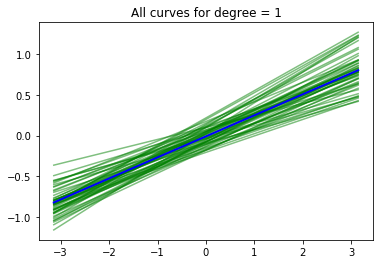

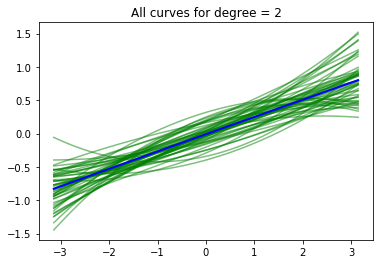

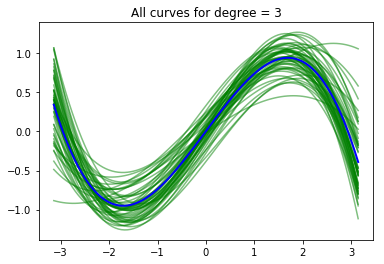

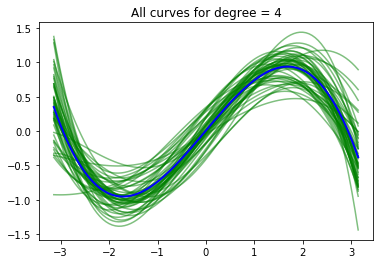

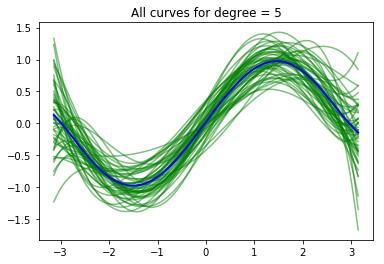

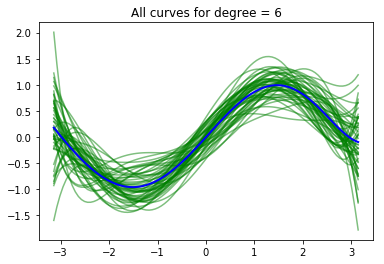

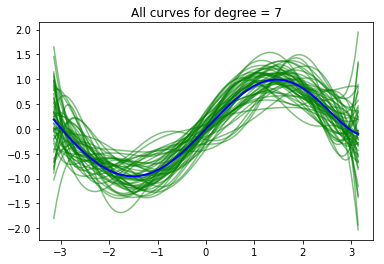

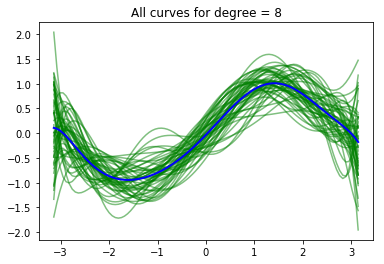

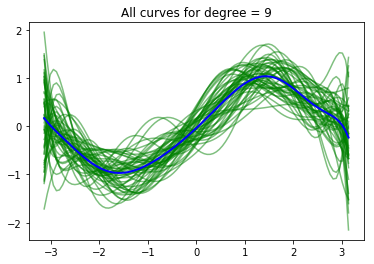

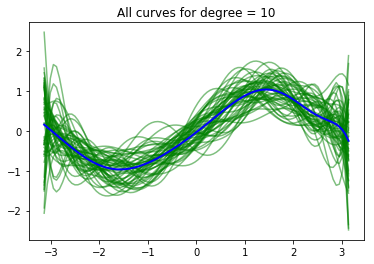

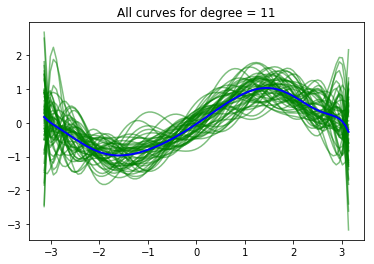

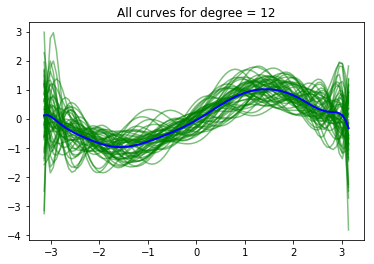

In [10]:
for d in range(maximum_polynomial_degree):
    for k in range(num_datasets):
        plt.plot(x_axis, prediction_curves[:,k,d], color='green', alpha=0.5)
    plt.plot(x_axis, prediction_curves[:,:,d].mean(axis=1), color='blue', linewidth=2)
    plt.title("All curves for degree = %d" % (d+1))
    plt.show()

Notice as the degree increases, the variance also increases. Our average trendline more-or-less does not change, just the noise surrounding the function.

## Find Average Train Bias

In [11]:
avg_train_prediction = np.zeros((Ntrain, maximum_polynomial_degree))
squared_bias = np.zeros(maximum_polynomial_degree)
f_X_train = f_X[:Ntrain]
for d in range(maximum_polynomial_degree):
    for i in range(Ntrain):
        avg_train_prediction[i,d] = train_predictions[i,:,d].mean()
    squared_bias[d] = ((avg_train_prediction[:,d] - f_X_train)**2).mean()

## Find Average Train Variance

In [12]:
variances = np.zeros((Ntrain, maximum_polynomial_degree))
f_X_train = f_X[:Ntrain]
for d in range(maximum_polynomial_degree):
    for i in range(Ntrain):
        delta = train_predictions[i,:,d] - avg_train_prediction[i,d]
        variances[i,d] = delta.dot(delta) / N
variance = variances.mean(axis=0)

## Plot Best Degree

The best degree to use should be determined by the minimum test score.

In [13]:
degrees = np.arange(maximum_polynomial_degree) + 1
best_degree = np.argmin(test_scores.mean(axis=0)) + 1

## Evaluate Visually

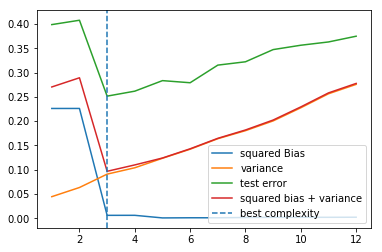

In [16]:
plt.plot(degrees, squared_bias, label='squared Bias')
plt.plot(degrees, variance, label='variance')
plt.plot(degrees, test_scores.mean(axis=0), label='test error')
plt.plot(degrees, squared_bias + variance, label='squared bias + variance')
plt.axvline(x=best_degree, ls='--', label='best complexity')
plt.legend()
plt.show()

Notice the bias decaying towards 0 as we increase the degree of our estimation function? At the same time, take a look at the variance - it is linearly increasing with the increase in degree.

The plot above demonstrates the crux of the bias-variance tradeoff and is a critical key to understanding how to build the most effective machine learning models.

## Plot Training and Test Scores Vs. Degrees

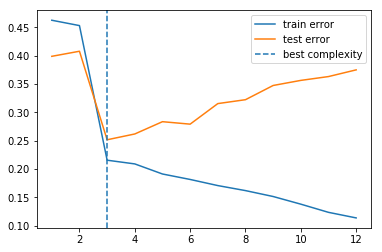

In [17]:
plt.plot(degrees, train_scores.mean(axis=0), label='train error')
plt.plot(degrees, test_scores.mean(axis=0), label='test error')
plt.axvline(x=best_degree, ls='--', label='best complexity')
plt.legend()
plt.show()

Notice above how the train and the test error above appear to be "fanning" outwards? This is due to the bias-variance tradeoff. Our model is learning based on the training data, and begins to overfit the data after polynomial degree 3. We say it is overfitting because the bias is near zero, but the variance continues to increase.

As a data scientist, always be leary of decreasing training error past a certain point, you may be ignoring the injection of added variance into your model.